In [1]:
import gc
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from lightgbm import early_stopping

warnings.filterwarnings('ignore')

In [2]:
NUM_FOLDS = 5

In [3]:
FEATURES = [
    'P_2', 'B_1', 'B_2', 'R_1', 'S_3', 'B_3', 'D_44', 'B_4', 'D_45', 'B_5',
    'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'B_9', 'D_52', 'P_3', 'B_11', 'S_7',
    'D_55', 'D_61', 'B_18', 'B_23', 'D_75', 'B_33', 'S_23', 'S_25', 'B_37',
    'R_27', 'B_40', 'c_PD_239', 'c_PB_29', 'c_PR_21', 'c_BBBB2', 'c_RRR0',
    'c_PD_348', 'c_PB_49', 'c_PR_41'
]

In [4]:
def features_process(df, label=None, test=False):
    global FEATURES
    def feature_select(df):
        X = df.drop(['customer_ID', 'S_2', 'target'], axis=1).fillna(-127)
        y = df['target']
        feature_names = list(X.columns)
        forest = RandomForestClassifier(random_state=0, n_jobs=-1, verbose=1)
        forest.fit(X, y)

        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
        
        forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        fig, ax = plt.subplots(figsize=(50, 50))
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title('Feature importances using MDI')
        ax.set_ylabel('Mean decrease in impurity')
        fig.tight_layout()
        plt.show()

        threshold = importances.mean() * 1.2
        print(np.sum(forest_importances > threshold))
        FEATURES = list(forest_importances.loc[forest_importances > threshold].index)
        print(FEATURES)
        

        # select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1, verbose=1), threshold='1.2*mean')
        # select.fit(X, y)
        # #   
        # features = 
        # FEATURES = list(X.columns[select.get_support()])
        
        # print(FEATURES)
        # df = df[FEATURES + ['target']]
        
        return df
    
    def polynomial_feature(df):
        categorical_features = [
            'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
            'D_126', 'D_63', 'D_64', 'D_66', 'D_68'
        ]
        num_features = []
        for col in [c for c in df.columns if c not in ['customer_ID', 'S_2', 'target']]:
            if col not in categorical_features:
                num_features.append(col)
                
        poly = PolynomialFeatures(degree=2, include_bias=False)
        df_poly = poly.fit_transform(df[num_features].fillna(-127))
        df[poly.get_feature_names(None)] = df_poly
        
        del df_poly
        return df
        

    
    print('groupby customer_ID tail(1)')
    df = df.groupby('customer_ID').tail(1).set_index('customer_ID')
    print('shape:', df.shape)

    if not test:
        print('dropna nan >= 80%')
        df = df.dropna(axis=1, thresh=int(0.8 * len(df)))
        print('shape:', df.shape)

    print('add features')
    df["c_PD_239"] = df["D_39"] / (df["P_2"] * (-1) + 0.0001)
    df["c_PB_29"] = df["P_2"] * (-1) / (df["B_9"] * (1) + 0.0001)
    df["c_PR_21"] = df["P_2"] * (-1) / (df["R_1"] + 0.0001)

    df["c_BBBB"] = (df["B_9"] + 0.001) / (df["B_23"] + df["B_3"] + 0.0001)
    df["c_BBBB1"] = (df["B_33"] * (-1)) + (df["B_18"] * (-1) + df["S_25"] * (1) + 0.0001)
    df["c_BBBB2"] = (df["B_19"] + df["B_20"] + df["B_4"] + 0.0001)

    df["c_RRR0"] = (df["R_3"] + 0.001) / (df["R_2"] + df["R_4"] + 0.0001)
    df["c_RRR1"] = (df["D_62"] + 0.001) / (df["D_112"] + df["R_27"] + 0.0001)

    df["c_PD_348"] = df["D_48"] / (df["P_3"] + 0.0001)
    df["c_PD_355"] = df["D_55"] / (df["P_3"] + 0.0001)

    df["c_PD_439"] = df["D_39"] / (df["P_4"] + 0.0001)
    df["c_PB_49"] = df["B_9"] / (df["P_4"] + 0.0001)
    df["c_PR_41"] = df["R_1"] / (df["P_4"] + 0.0001)
    print('shape:', df.shape)
    
    if label is not None:
        print('merge with label')
        df = df.merge(label, how='left', on='customer_ID')
        del label
        print('shape:', df.shape)
    
    print('feature select')
    if not test:
        df = feature_select(df)
        # df = df[FEATURES + ['target']]
    else:
        df = df[FEATURES]
    print('shape:', df.shape)
    
    # print('polynomial features')
    # df = polynomial_feature(df)
    # print('shape:', df.shape)
    
    
    return df

groupby customer_ID tail(1)
shape: (458913, 189)
dropna nan >= 80%
shape: (458913, 168)
add features
shape: (458913, 181)
merge with label
shape: (458913, 183)
feature select


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished


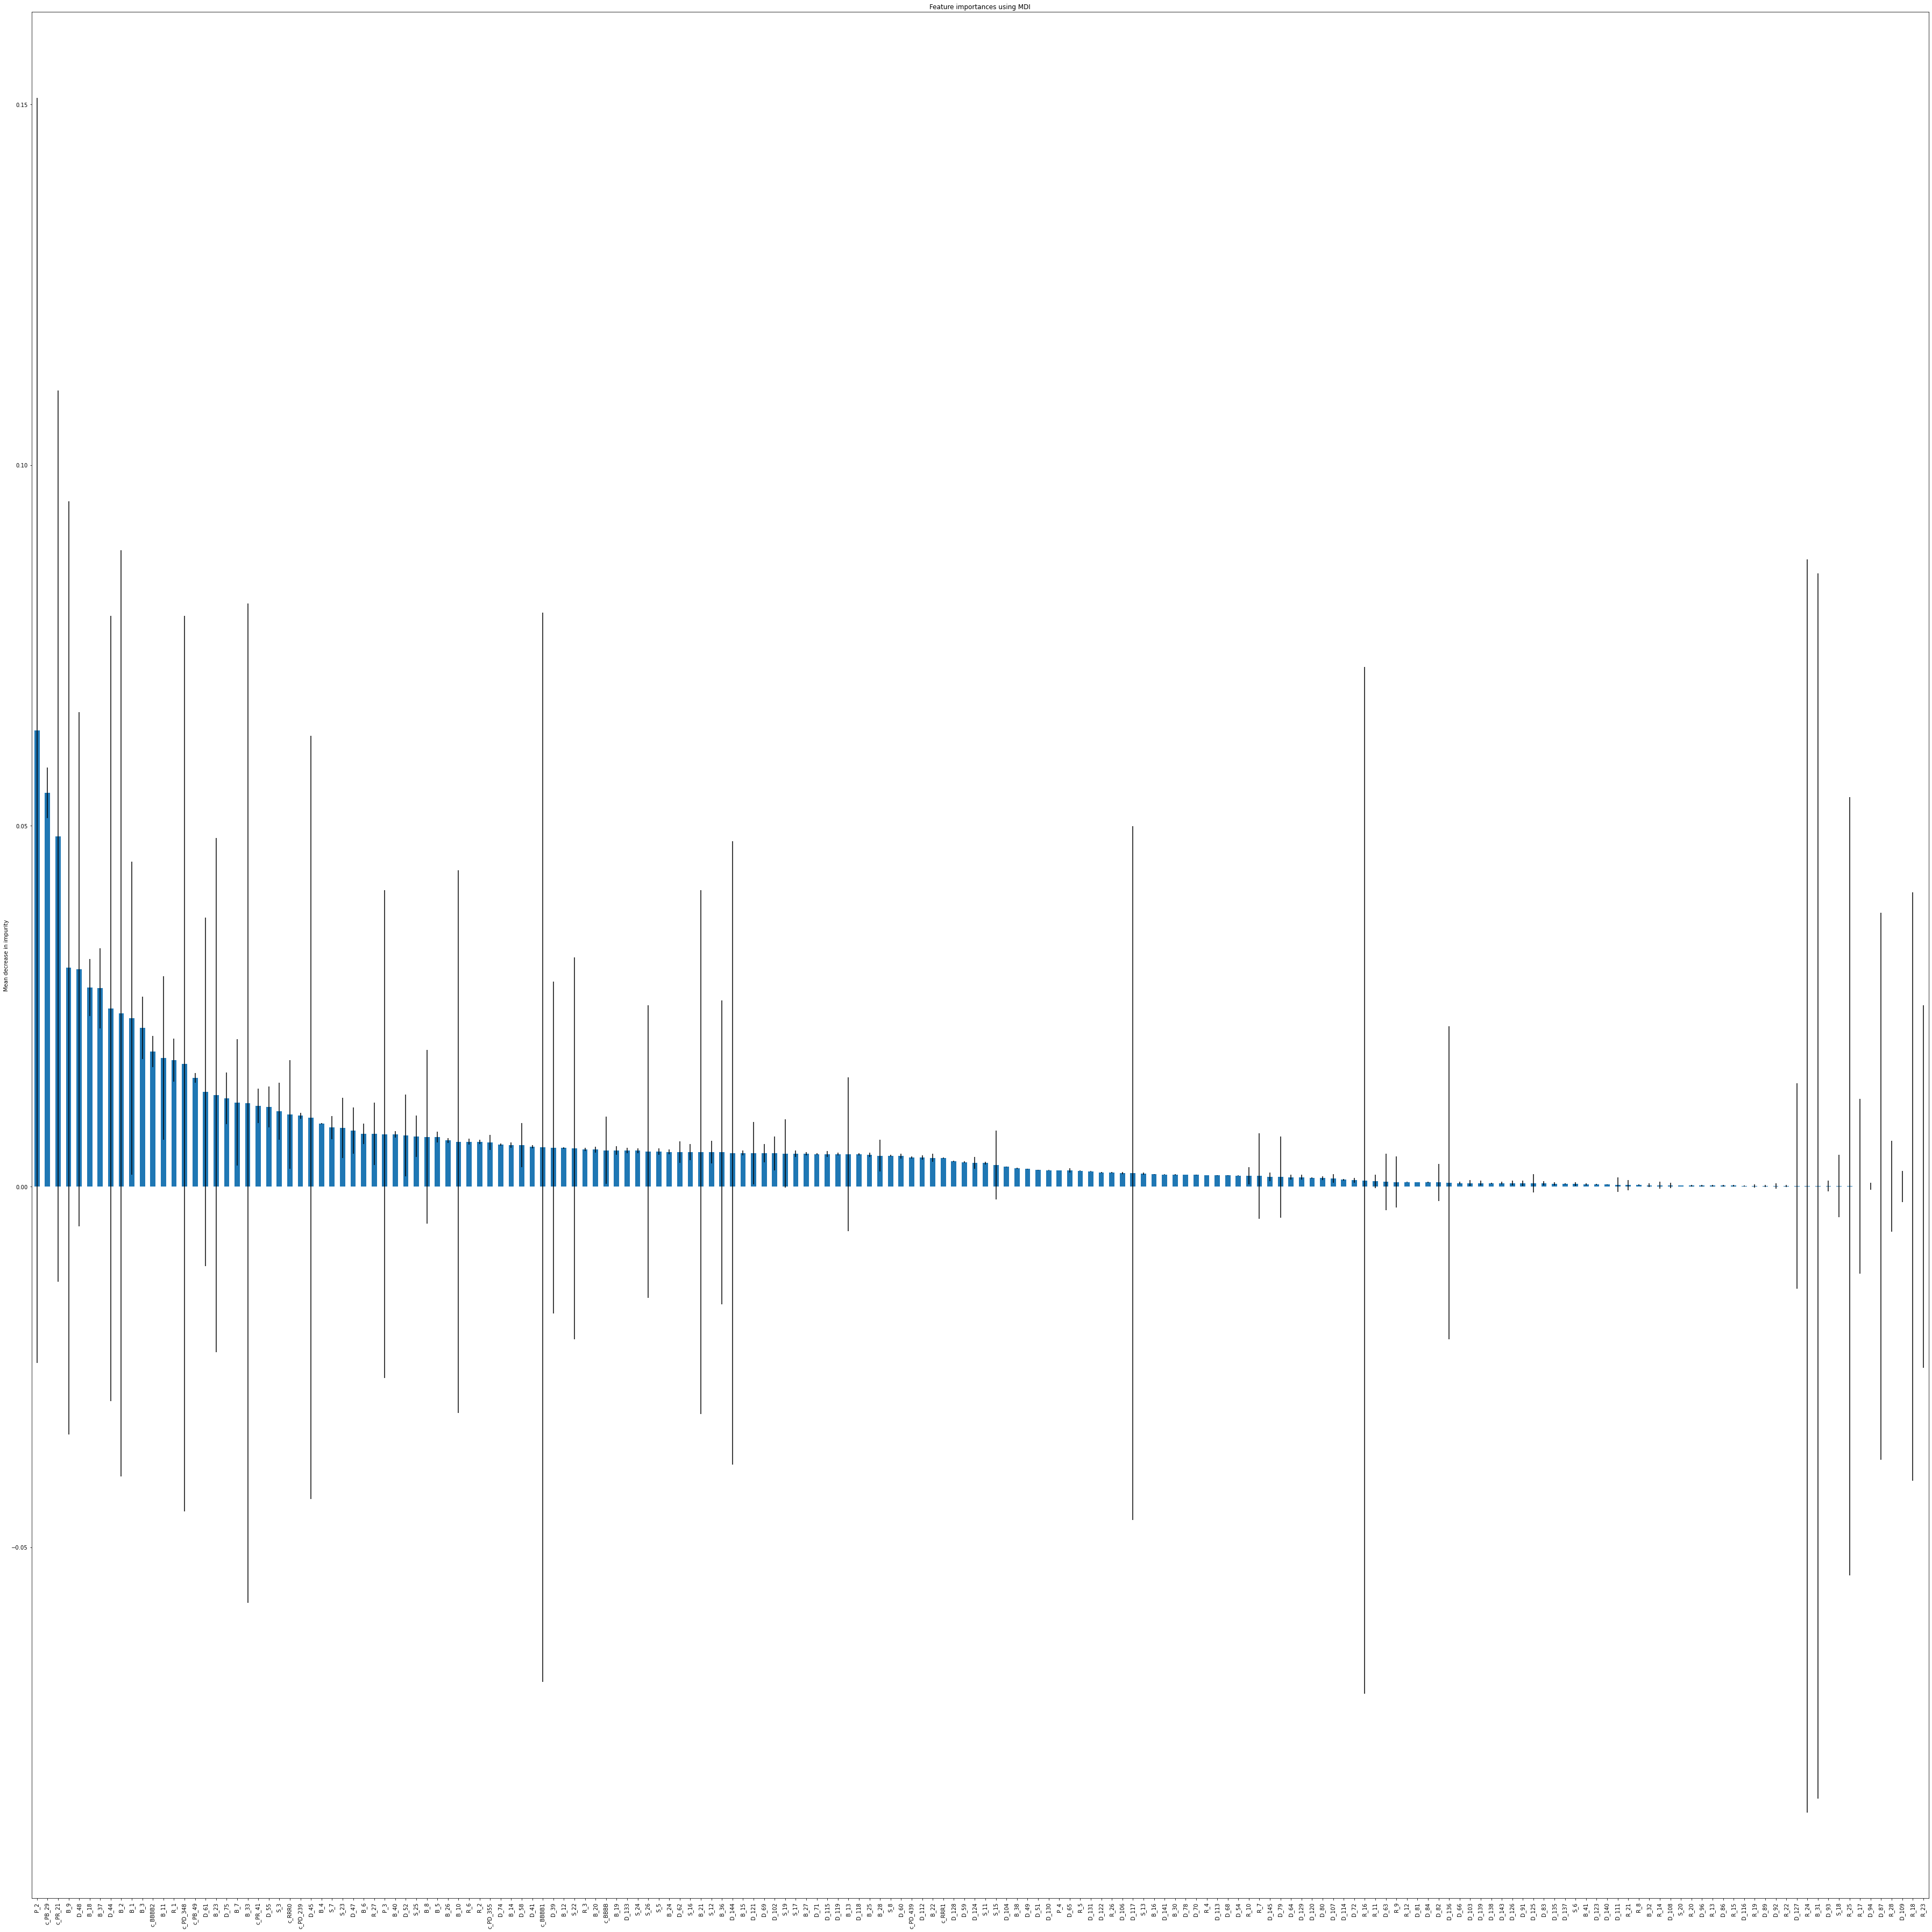

39
['P_2', 'c_PB_29', 'c_PR_21', 'B_9', 'D_48', 'B_18', 'B_37', 'D_44', 'B_2', 'B_1', 'B_3', 'c_BBBB2', 'B_11', 'R_1', 'c_PD_348', 'c_PB_49', 'D_61', 'B_23', 'D_75', 'B_7', 'B_33', 'c_PR_41', 'D_55', 'S_3', 'c_RRR0', 'c_PD_239', 'D_45', 'B_4', 'S_7', 'S_23', 'D_47', 'B_6', 'R_27', 'P_3', 'B_40', 'D_52', 'S_25', 'B_8', 'B_5']
shape: (458913, 183)
Wall time: 1min 20s


27454

In [5]:
%%time

df_train = pd.read_parquet('./data/train.parquet')
df_train_label = pd.read_csv('./data/train_labels.csv')
df_train = features_process(df_train, label=df_train_label)

del df_train_label
gc.collect()

In [ ]:
df_train

In [ ]:
df_train.info()

In [ ]:
categorical_cols = [
    'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
    'D_126', 'D_63', 'D_64', 'D_66', 'D_68'
]

cat_col = []
categorical_cols_ = []
n = 0
for col in df_train.columns:
    for coll in categorical_cols:
        if col == coll:
            cat_col.append(n)
            categorical_cols_.append(col)
            break
    n += 1
print(cat_col)
print(categorical_cols_)

In [ ]:
# https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793/notebook
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):
    
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1] / gini[0] + top_four), _

In [ ]:
%%time
params = {}
feature_importances = []  # 특성 중요도 
scores = []               # fold 별 점수 
models = []               # 모델 
pred_val = []
yval = []

X = df_train.drop(['target'], axis=1)
y = df_train['target']

# 교차 검증 클래스
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2022)

# 폴드별 데이터 나누기 
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train[FEATURES], df_train["target"])):
    
    print('FOLD:', fold)
    
    # 데이터 나누기
    X_train = X.loc[train_idx].values
    y_train = y.loc[train_idx].values
    X_val = X.loc[val_idx].values
    y_val = y.loc[val_idx].values

    print("y_train t=0 count:", len(y_train[y_train == 0]))
    print("y_train t=1 count:", len(y_train[y_train == 1]))
    print("y_val t=0 count:", len(y_val[y_val == 0]))
    print("y_val t=1 count:", len(y_val[y_val == 1]))


    params = {
        "num_iterations": 10000,
        'learning_rate': 0.05,
    }
    
    # LGBM 알고리즘
    model = lgbm.LGBMClassifier(**params).fit(
        X_train,y_train,
        eval_set=[(X_val, y_val), (X_train, y_train)],
        verbose=100,
        callbacks=[early_stopping(100)],
        categorical_feature=cat_col
    )
    
    # 특성 중요도
    feature_importances.append(model.feature_importances_)   
    models.append(model)
    pred_val = np.append(pred_val, model.predict_proba(X_val)[:, 1])
    yval = np.append(yval, y_val)   
    
    del X_train, y_train, X_val, y_val, model
    gc.collect()


score = amex_metric_mod(yval, pred_val)[0]
print('score:', score)
with open('score_lightgbm_poly.txt', 'w') as f:
    f.write(str(score))
# f = open("lightgbm_score.txt", "a")
# f.write(str(score))
# f.close()

In [ ]:
del df_train, train_idx, val_idx, yval, pred_val, X, y
gc.collect()

In [ ]:
df_feat_imp = pd.DataFrame(index=FEATURES)
df_feat_imp["imp0"] = feature_importances[0]
df_feat_imp["imp1"] = feature_importances[1]
df_feat_imp["imp2"] = feature_importances[2]
df_feat_imp["imp3"] = feature_importances[3]
df_feat_imp["imp4"] = feature_importances[4]
df_feat_imp["mean_imp"] = df_feat_imp.mean(axis=1).values

df_feat_imp = df_feat_imp.sort_values(by="mean_imp",ascending=False)

df_feat_imp.to_csv("feat_imp_poly.csv")

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=df_feat_imp.index,y=df_feat_imp["mean_imp"])
plt.xticks([])
print(df_feat_imp)

In [ ]:
df_test = pd.read_parquet('./data/test.parquet')

df_test = features_process(df_test, test=True)
gc.collect()

In [ ]:
df_test.info()

In [ ]:
print("prediction")
pred = []
for fold in range(5):
    print('FOLD:', fold)

    if len(pred) == 0:
        pred = models[fold].predict_proba(df_test)[:, 1]
    else:
        pred += models[fold].predict_proba(df_test)[:, 1]

pred = pred / 5

In [ ]:
subm = pd.read_csv('./data/sample_submission.csv')
subm["prediction"] = pred
subm.to_csv("submission_lightgbm_poly.csv", index=False)